In [70]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from joblib import Parallel, delayed

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import numpy as np
import scipy.stats
from functools import partial
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator


def mean_confidence_interval(data, confidence=0.95):
    """ Calculate mean, lower and upper bound of confidence interval """
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def Dxy(e,y,x):
    """ Calculate Dxy """
    #return 2 * concordance_index_censored(e, y, x)[0] - 1
    return 2 * concordance_index(y, x, e) - 1


def bootstrap_dxy_inner(df):
    e, y, x = df.columns
    sample = df.sample(df.shape[0], replace=True)
    
    # calculate Dxy
    return Dxy(sample[e], sample[y], sample[x])


def bootstrap_dxy(df, n=5):
    """ Boostrap and calculate Dxy """
    # resample n times
    result = Parallel(n_jobs=-1)(delayed(bootstrap_dxy_inner)(df) for i in range(n))

    return result

def apply_stats_for_each_value(df, fmap, condition_names=None):
    """ Apply stats to each value in column """

    all_count = df.shape[0]
    
    dff = pd.DataFrame({'E':df['E'], 'Y':df['Y'], 'agg':df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    
    stats = dff['Y'].aggregate(['count', 'median'])
    
    dxy_bootstraped = bootstrap_dxy(dff[['E', 'Y', 'agg']])
    # confidence interval
    dxy, ci_low, ci_high =  mean_confidence_interval(dxy_bootstraped)
    
    ret = {
        'Number of patiets' : stats['count'],
        '% z całej kohorty': np.round(selected_count/all_count, 2),
        'Survival days, median' : stats['median'],
        'Survival years, median' : stats['median']/365 ,
        'Dxy': np.round(dxy, 2), 
        'Confidence interval 95% low': np.round(ci_low, 2),
        'Confidence interval 95% high': np.round(ci_high, 2),
    }
    result = pd.DataFrame(ret, index=(0,))

    groups = dff.groupby(by=['agg'])['Y'].aggregate(['count', 'median', 'min', 'max', 'std','mean'])
    
    if condition_names:
        groups.index = groups.index.map(condition_names)
    #groups.columns = ['Number of patiets', 'Survival days, median', 'min', 'max', 'std']
    
    for value in dff["agg"].unique():
        mask = (dff["agg"] == value)
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label="%s (n = %d)" % (condition_names[value], mask.sum()))

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.show()
    plt.clf()
    return result, groups

In [68]:
DATA_PREFIX="~/secret_life_of_CVEs/data/"

In [27]:
unique_cve_info_cvss_cwe_etc_df_filename = DATA_PREFIX + 'unique_cve_info-cvss_cwe_etc.parquet'
cve_lifespan_language_df_filename = DATA_PREFIX + 'cve_lifespan_language_df'
unique_cve_info_cvss_cwe_etc_df = pd.read_parquet(unique_cve_info_cvss_cwe_etc_df_filename)
cve_lifespan_language_df_df = pd.read_parquet(cve_lifespan_language_df_filename)
commits_df = cve_lifespan_language_df_df.drop_duplicates()
commits_df['cve'] = commits_df['commit_cves']
df = commits_df.merge(unique_cve_info_cvss_cwe_etc_df.drop('error', axis='columns'), on='cve')

/tmp/ipykernel_3436990/572894398.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  commits_df['cve'] = commits_df['commit_cves']


In [28]:
df['E'] = True
df['Y']=df['cve_lifespan_commiter_time'].dt.days

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.05,0.05,0.06


,count,median,min,max,std,mean
agg,,,,,,
procedural,243415,310.0,0,8019,1081.333218,758.433786
scripting,4172,870.0,0,5465,925.984887,1033.479626
functional,38909,639.0,0,7538,1066.987307,1000.239405


(None, None)

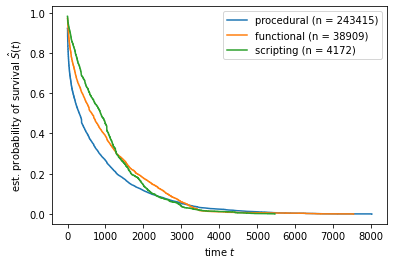

In [30]:
def f_map_pp(x):
    a = int(x['programming_paradigm'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    if a == 3:
        return 3
    else:
        return 0

condition_names_pp = {1 : 'procedural', 2: 'scripting', 3:'functional', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df, f_map_pp, condition_names_pp)
display(S1), display(S2)

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,-0.02,-0.02,-0.02


,count,median,min,max,std,mean
agg,,,,,,
static,136291,370.0,0,8019,1188.866172,852.111401
dynamic,150205,321.0,0,8019,969.634849,743.710509


(None, None)

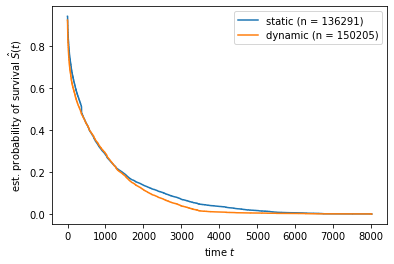

In [31]:
def f_map_cc(x):
    a = int(x['compilation_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names_cc = {1 : 'static', 2: 'dynamic', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df, f_map_cc, condition_names_cc)
display(S1), display(S2)

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
strong,138645,344.0,0,8019,975.572232,747.194028
weak,147851,360.0,0,8019,1169.209591,840.369264


(None, None)

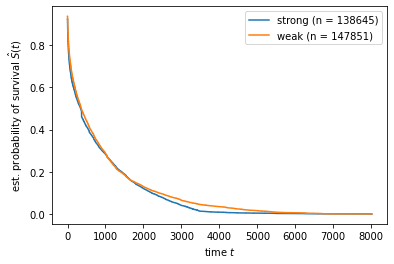

In [32]:
def f_map_tc(x):
    a = int(x['type_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names_tc = {1 : 'strong', 2: 'weak', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df, f_map_tc, condition_names_tc)
display(S1), display(S2)

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.01,0.01,0.01


,count,median,min,max,std,mean
agg,,,,,,
managed,227287,354.0,0,8019,1022.505880,771.732048
non managed,59209,357.0,0,8019,1276.333511,885.667551


(None, None)

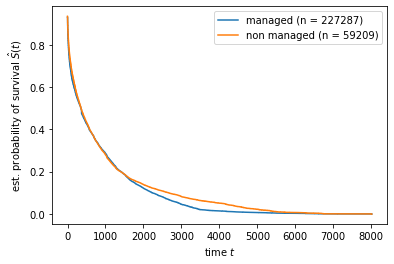

In [33]:
def f_map_mm(x):
    a = int(x['memory_model'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names_mm = {1 : 'managed', 2: 'non managed', 0: 'other'}

S1, S2 = apply_stats_for_each_value(df, f_map_mm, condition_names_mm)
display(S1), display(S2)

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,-0.07,-0.07,-0.06


,count,median,min,max,std,mean
agg,,,,,,
lang_Ada,2606,1177.0,0,5766,1029.032617,1375.912510
lang_Assembly,10657,455.0,0,7538,915.955286,811.376466
lang_C,42902,260.0,0,8019,1379.001766,852.386392
lang_C#,3106,1136.0,0,5766,1085.186408,1352.078880
lang_C++,27564,218.0,0,8019,1125.168394,700.524634
lang_Clojure,9328,217.0,0,7538,960.116373,632.915523
lang_Common Lisp,5892,1033.0,0,7538,1035.755579,1265.197047
lang_Elixir,255,363.0,0,4791,1024.259942,878.188235
lang_Emacs Lisp,3269,916.0,0,5766,1045.764095,1205.163965


(None, None)

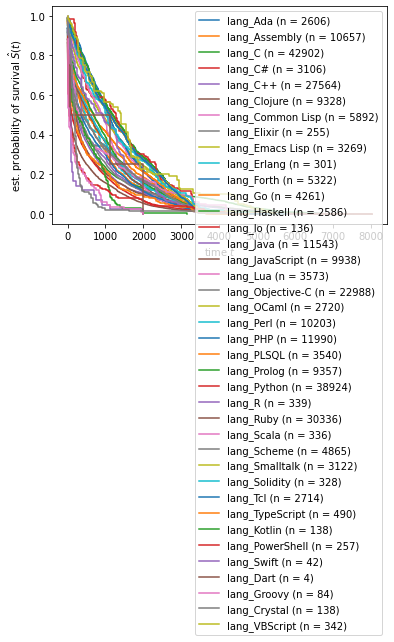

In [55]:
languagesl = df['value'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names_mm = dict(zip(range(len(languagesl)), languagesl))

def f_map_mm(x):
    a = x['value']
    return languages[a]


S1, S2 = apply_stats_for_each_value(df, f_map_mm, condition_names_mm)
display(S1), display(S2)

In [57]:
df.head()

,commit_cves,project_names,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,variable,value,programming_paradigm,compilation_class,...,cwe,cvss-vector,access.authentication,access.complexity,access.vector,impact.availability,impact.confidentiality,impact.integrity,E,Y
0,CVE-2014-3470,pagodabox_nanobox-pkgsrc-lite,339 days 00:11:42,344 days 01:42:00,False,False,lang_Ada,lang_Ada,1,1,...,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,True,339
1,CVE-2014-3470,bitbucket.org_cagney_netbsd,477 days 23:03:35,483 days 00:33:53,False,False,lang_Ada,lang_Ada,1,1,...,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,True,477
2,CVE-2014-3470,NetBSD_src,2 days 15:13:41,7 days 16:43:59,True,False,lang_Assembly,lang_Assembly,1,1,...,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,True,2
3,CVE-2014-3470,pagodabox_nanobox-pkgsrc-lite,339 days 00:11:42,344 days 01:42:00,False,False,lang_Assembly,lang_Assembly,1,1,...,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,True,339
4,CVE-2014-3470,bitbucket.org_cagney_netbsd,477 days 23:03:35,483 days 00:33:53,False,False,lang_Assembly,lang_Assembly,1,1,...,CWE-310,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,True,477


,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.03,0.03,0.03


,count,median,min,max,std,mean
agg,,,,,,
NETWORK,217909,338.0,0,8019,927.010058,730.287909
LOCAL,60715,386.0,0,7538,1422.772836,977.311422
ADJACENT_NETWORK,6837,532.0,0,6839,1675.245537,1240.643118
<NA>,1035,575.0,0,6012,1009.880594,858.071498


(None, None)

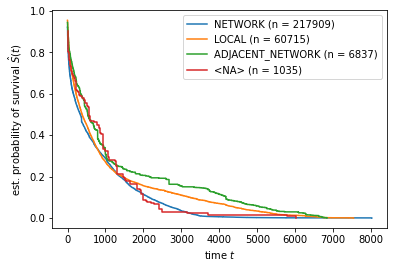

In [58]:
languagesl = df['access.vector'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names_mm = dict(zip(range(len(languagesl)), languagesl))

def f_map_mm(x):
    a = x['access.vector']
    return languages[a]


S1, S2 = apply_stats_for_each_value(df, f_map_mm, condition_names_mm)
display(S1), display(S2)

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,-0.0,-0.01,-0.0


,count,median,min,max,std,mean
agg,,,,,,
MEDIUM,108930,371.0,0,6820,1080.873425,818.350161
LOW,162610,332.0,0,8019,1029.881879,746.781379
HIGH,13921,435.0,0,7022,1502.804741,1176.571008
<NA>,1035,575.0,0,6012,1009.880594,858.071498


(None, None)

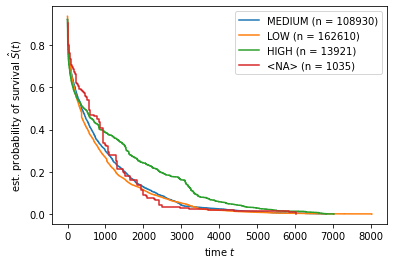

In [60]:
languagesl = df['access.complexity'].unique()

languages = dict(zip(languagesl, range(len(languagesl))))

condition_names_mm = dict(zip(range(len(languagesl)), languagesl))

def f_map_mm(x):
    a = x['access.complexity']
    return languages[a]


S1, S2 = apply_stats_for_each_value(df, f_map_mm, condition_names_mm)
ddisplay(S1), display(S2)

In [76]:
def naive_compute(vname):

    print(vname)
    typesl = df[vname].unique()

    types = dict(zip(typesl, range(len(typesl))))
    print(types)


    condition_names_mm = dict(zip(range(len(typesl)), typesl))

    def f_map_mm(x):
        a = x[vname]
        return types[a]


    S1, S2 = apply_stats_for_each_value(df, f_map_mm, condition_names_mm)
    display(S1), display(S2)

In [81]:
vnames = ['value', 'programming_paradigm', 'compilation_class', 'type_class',
       'memory_model', 'cvss', 'cwe', 'cvss-vector',
       'access.authentication', 'access.complexity', 'access.vector',
       'impact.availability', 'impact.confidentiality', 'impact.integrity']

value
{'lang_Ada': 0, 'lang_Assembly': 1, 'lang_C': 2, 'lang_C#': 3, 'lang_C++': 4, 'lang_Clojure': 5, 'lang_Common Lisp': 6, 'lang_Elixir': 7, 'lang_Emacs Lisp': 8, 'lang_Erlang': 9, 'lang_Forth': 10, 'lang_Go': 11, 'lang_Haskell': 12, 'lang_Io': 13, 'lang_Java': 14, 'lang_JavaScript': 15, 'lang_Lua': 16, 'lang_Objective-C': 17, 'lang_OCaml': 18, 'lang_Perl': 19, 'lang_PHP': 20, 'lang_PLSQL': 21, 'lang_Prolog': 22, 'lang_Python': 23, 'lang_R': 24, 'lang_Ruby': 25, 'lang_Scala': 26, 'lang_Scheme': 27, 'lang_Smalltalk': 28, 'lang_Solidity': 29, 'lang_Tcl': 30, 'lang_TypeScript': 31, 'lang_Kotlin': 32, 'lang_PowerShell': 33, 'lang_Swift': 34, 'lang_Dart': 35, 'lang_Groovy': 36, 'lang_Crystal': 37, 'lang_VBScript': 38}


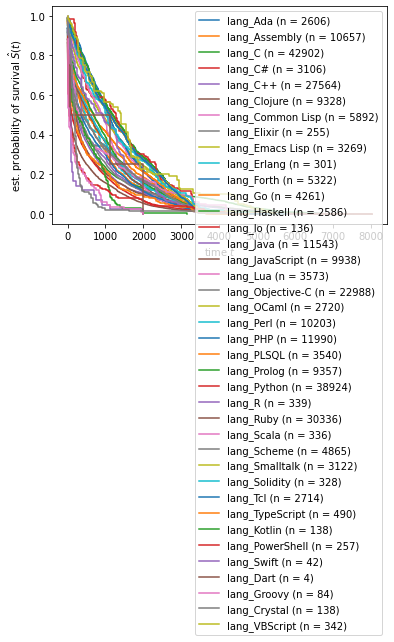

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,-0.07,-0.07,-0.06


,count,median,min,max,std,mean
agg,,,,,,
lang_Ada,2606,1177.0,0,5766,1029.032617,1375.912510
lang_Assembly,10657,455.0,0,7538,915.955286,811.376466
lang_C,42902,260.0,0,8019,1379.001766,852.386392
lang_C#,3106,1136.0,0,5766,1085.186408,1352.078880
lang_C++,27564,218.0,0,8019,1125.168394,700.524634
lang_Clojure,9328,217.0,0,7538,960.116373,632.915523
lang_Common Lisp,5892,1033.0,0,7538,1035.755579,1265.197047
lang_Elixir,255,363.0,0,4791,1024.259942,878.188235
lang_Emacs Lisp,3269,916.0,0,5766,1045.764095,1205.163965


programming_paradigm
{1: 0, 3: 1, 2: 2}


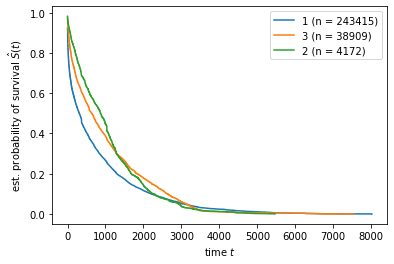

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.05,0.05,0.06


,count,median,min,max,std,mean
agg,,,,,,
1,243415,310.0,0,8019,1081.333218,758.433786
3,38909,639.0,0,7538,1066.987307,1000.239405
2,4172,870.0,0,5465,925.984887,1033.479626


compilation_class
{1: 0, 2: 1}


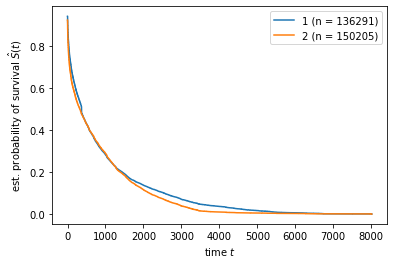

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,-0.02,-0.02,-0.02


,count,median,min,max,std,mean
agg,,,,,,
1,136291,370.0,0,8019,1188.866172,852.111401
2,150205,321.0,0,8019,969.634849,743.710509


type_class
{1: 0, 2: 1}


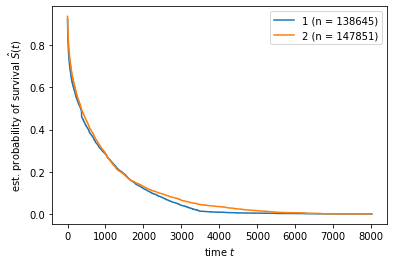

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
1,138645,344.0,0,8019,975.572232,747.194028
2,147851,360.0,0,8019,1169.209591,840.369264


memory_model
{1: 0, 2: 1}


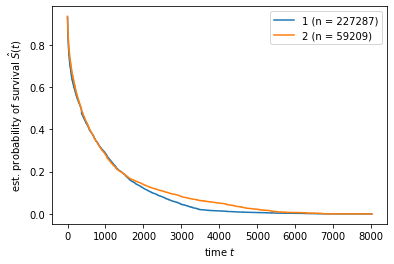

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.01,0.01,0.01


,count,median,min,max,std,mean
agg,,,,,,
1,227287,354.0,0,8019,1022.505880,771.732048
2,59209,357.0,0,8019,1276.333511,885.667551


cvss
{4.3: 0, 6.8: 1, 5.0: 2, 5.8: 3, 10.0: 4, 9.3: 5, 7.5: 6, 7.8: 7, 8.5: 8, 6.5: 9, 4.0: 10, 2.1: 11, 1.9: 12, 4.6: 13, 2.6: 14, 1.2: 15, 7.6: 16, 6.9: 17, <NA>: 18, 6.2: 19, 5.1: 20, 4.4: 21, 6.4: 22, 7.2: 23, 9.0: 24, 6.1: 25, 3.5: 26, 3.6: 27, 5.5: 28, 7.1: 29, 4.7: 30, 3.3: 31, 4.9: 32, 2.7: 33, 6.6: 34, 5.2: 35, 1.7: 36, 6.3: 37, 3.7: 38, 6.0: 39, 7.4: 40, 5.4: 41, 8.3: 42, 1.5: 43, 5.7: 44, 2.9: 45, 6.7: 46, 7.9: 47, 3.8: 48, 1.8: 49, 9.4: 50, 7.7: 51, 5.6: 52, 5.9: 53, 3.2: 54, 2.3: 55, 4.8: 56, 8.0: 57, 8.8: 58, 1.0: 59, 4.1: 60, 2.8: 61, 3.4: 62, 0.0: 63}


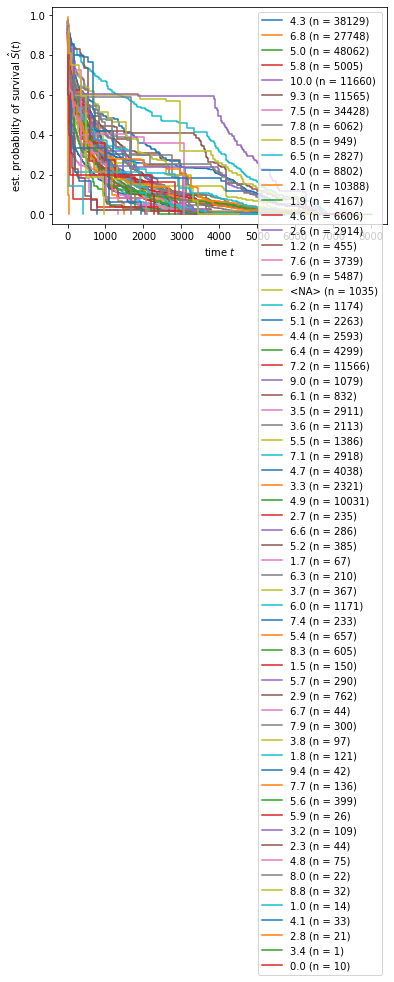

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.01,0.01,0.01


,count,median,min,max,std,mean
agg,,,,,,
4.3,38129,353.0,0,6756,875.306617,705.351570
6.8,27748,367.0,0,6691,948.303768,766.203618
5.0,48062,337.0,0,8019,920.479609,747.310203
5.8,5005,225.0,0,4532,781.447478,575.169031
10.0,11660,568.0,0,7454,957.508107,843.418353
...,...,...,...,...,...,...
1.0,14,12.0,12,405,140.583869,73.857143
4.1,33,78.0,0,1938,606.576516,438.484848
2.8,21,3.0,2,28,8.274171,8.190476


cwe
{'CWE-310': 0, 'CWE-189': 1, 'CWE-399': 2, 'CWE-264': 3, 'CWE-119': 4, 'CWE-20': 5, 'NVD-CWE-noinfo': 6, 'CWE-200': 7, 'CWE-326': 8, 'CWE-255': 9, 'CWE-125': 10, 'CWE-79': 11, 'CWE-352': 12, 'CWE-89': 13, 'NVD-CWE-Other': 14, 'CWE-17': 15, 'CWE-209': 16, 'CWE-362': 17, 'CWE-59': 18, 'CWE-287': 19, 'CWE-476': 20, 'CWE-787': 21, <NA>: 22, 'CWE-134': 23, 'CWE-94': 24, 'CWE-120': 25, 'CWE-284': 26, 'CWE-16': 27, 'CWE-190': 28, 'CWE-22': 29, 'CWE-416': 30, 'CWE-295': 31, 'CWE-78': 32, 'CWE-331': 33, 'CWE-669': 34, 'CWE-400': 35, 'CWE-835': 36, 'CWE-415': 37, 'CWE-401': 38, 'CWE-203': 39, 'CWE-77': 40, 'CWE-426': 41, 'CWE-384': 42, 'CWE-122': 43, 'CWE-358': 44, 'CWE-863': 45, 'CWE-297': 46, 'CWE-502': 47, 'CWE-116': 48, 'CWE-613': 49, 'CWE-681': 50, 'CWE-772': 51, 'CWE-191': 52, 'CWE-704': 53, 'CWE-193': 54, 'CWE-611': 55, 'CWE-19': 56, 'CWE-332': 57, 'CWE-345': 58, 'CWE-915': 59, 'CWE-369': 60, 'CWE-74': 61, 'CWE-732': 62, 'CWE-377': 63, 'CWE-824': 64, 'CWE-776': 65, 'CWE-522': 66, 'CWE

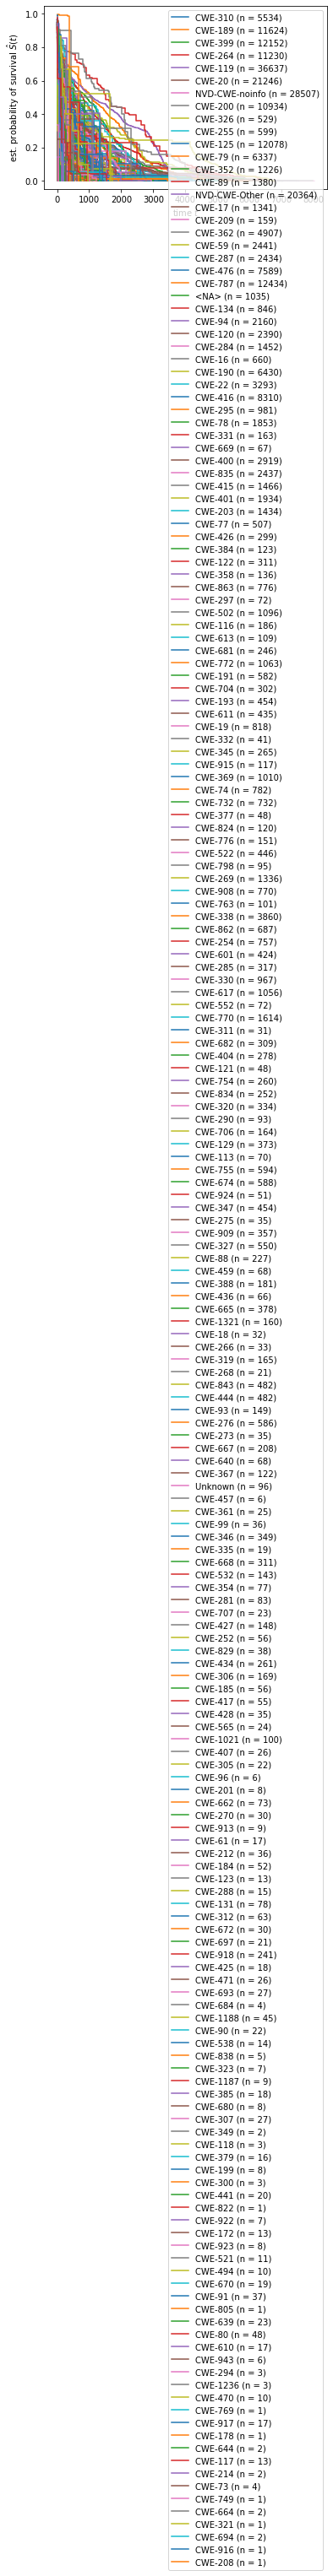

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,-0.13,-0.13,-0.13


,count,median,min,max,std,mean
agg,,,,,,
CWE-310,5534,546.0,0,7043,1064.439799,932.874955
CWE-189,11624,1056.0,0,6756,1279.340530,1362.409498
CWE-399,12152,908.0,0,7458,1179.316949,1145.400346
CWE-264,11230,807.0,0,6820,1403.793003,1246.788958
CWE-119,36637,595.0,0,6756,1039.016881,933.948986
...,...,...,...,...,...,...
CWE-664,2,0.0,0,0,0.000000,0.000000
CWE-321,1,270.0,270,270,NaN,270.000000
CWE-694,2,66.0,66,66,0.000000,66.000000


cvss-vector
{'AV:N/AC:M/Au:N/C:N/I:N/A:P': 0, 'AV:N/AC:M/Au:N/C:P/I:P/A:P': 1, 'AV:N/AC:L/Au:N/C:N/I:N/A:P': 2, 'AV:N/AC:M/Au:N/C:P/I:P/A:N': 3, 'AV:N/AC:L/Au:N/C:C/I:C/A:C': 4, 'AV:N/AC:M/Au:N/C:P/I:N/A:N': 5, 'AV:N/AC:L/Au:N/C:P/I:N/A:N': 6, 'AV:N/AC:M/Au:N/C:C/I:C/A:C': 7, 'AV:N/AC:L/Au:N/C:P/I:P/A:P': 8, 'AV:N/AC:L/Au:N/C:N/I:N/A:C': 9, 'AV:N/AC:L/Au:N/C:C/I:N/A:P': 10, 'AV:N/AC:L/Au:S/C:P/I:P/A:P': 11, 'AV:N/AC:M/Au:N/C:N/I:P/A:P': 12, 'AV:N/AC:M/Au:N/C:N/I:P/A:N': 13, 'AV:N/AC:H/Au:N/C:P/I:P/A:N': 14, 'AV:N/AC:L/Au:S/C:P/I:N/A:N': 15, 'AV:L/AC:L/Au:N/C:N/I:N/A:P': 16, 'AV:N/AC:H/Au:N/C:N/I:P/A:P': 17, 'AV:L/AC:M/Au:N/C:N/I:N/A:P': 18, 'AV:L/AC:L/Au:N/C:P/I:P/A:P': 19, 'AV:A/AC:M/Au:S/C:N/I:P/A:C': 20, 'AV:N/AC:H/Au:N/C:N/I:P/A:N': 21, 'AV:L/AC:H/Au:N/C:P/I:N/A:N': 22, 'AV:L/AC:M/Au:N/C:P/I:N/A:N': 23, 'AV:N/AC:H/Au:N/C:C/I:C/A:C': 24, 'AV:L/AC:M/Au:N/C:C/I:C/A:C': 25, <NA>: 26, 'AV:N/AC:H/Au:S/C:P/I:P/A:P': 27, 'AV:L/AC:H/Au:N/C:C/I:C/A:C': 28, 'AV:N/AC:H/Au:N/C:P/I:P/A:P': 29, '

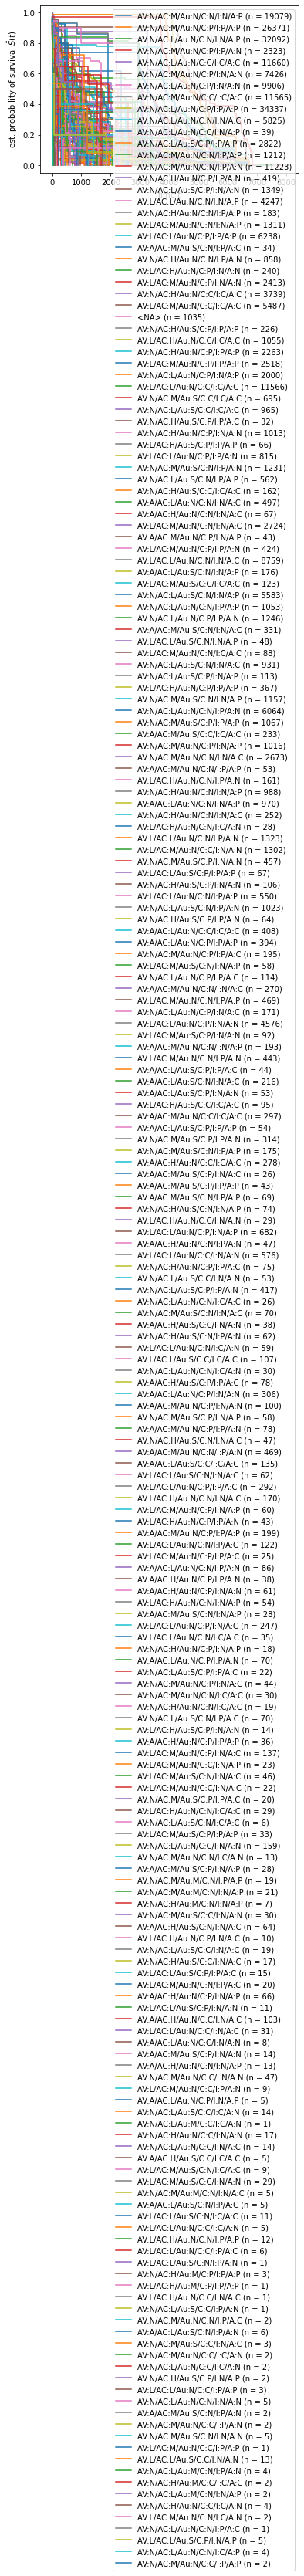

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,-0.02,-0.02,-0.01


,count,median,min,max,std,mean
agg,,,,,,
AV:N/AC:M/Au:N/C:N/I:N/A:P,19079,463.0,0,5139,833.479971,770.484826
AV:N/AC:M/Au:N/C:P/I:P/A:P,26371,364.0,0,5784,886.416370,740.714345
AV:N/AC:L/Au:N/C:N/I:N/A:P,32092,394.0,0,8019,930.737491,792.152780
AV:N/AC:M/Au:N/C:P/I:P/A:N,2323,256.0,0,3510,745.548349,570.414981
AV:N/AC:L/Au:N/C:C/I:C/A:C,11660,568.0,0,7454,957.508107,843.418353
...,...,...,...,...,...,...
AV:L/AC:M/Au:N/C:N/I:C/A:N,2,560.0,560,560,0.000000,560.000000
AV:N/AC:L/Au:N/C:N/I:P/A:C,1,16.0,16,16,NaN,16.000000
AV:L/AC:L/Au:S/C:P/I:N/A:P,5,64.0,0,1859,817.685636,397.400000


access.authentication
{'NONE': 0, 'SINGLE': 1, <NA>: 2, 'MULTIPLE': 3}


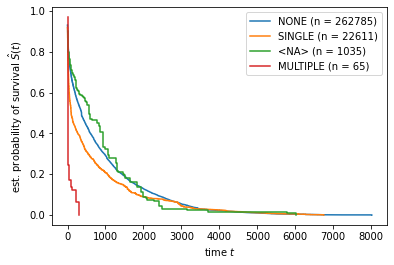

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,-0.03,-0.03,-0.03


,count,median,min,max,std,mean
agg,,,,,,
NONE,262785,370.0,0,8019,1081.668428,810.709964
SINGLE,22611,95.0,0,6756,1058.705655,615.215293
<NA>,1035,575.0,0,6012,1009.880594,858.071498
MULTIPLE,65,15.0,2,313,87.265064,46.107692


access.complexity
{'MEDIUM': 0, 'LOW': 1, 'HIGH': 2, <NA>: 3}


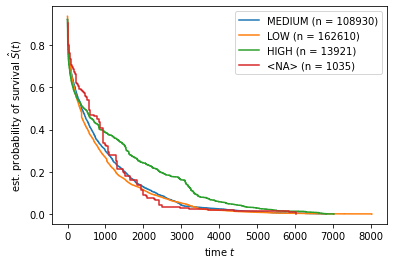

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,-0.01,-0.01,-0.0


,count,median,min,max,std,mean
agg,,,,,,
MEDIUM,108930,371.0,0,6820,1080.873425,818.350161
LOW,162610,332.0,0,8019,1029.881879,746.781379
HIGH,13921,435.0,0,7022,1502.804741,1176.571008
<NA>,1035,575.0,0,6012,1009.880594,858.071498


access.vector
{'NETWORK': 0, 'LOCAL': 1, 'ADJACENT_NETWORK': 2, <NA>: 3}


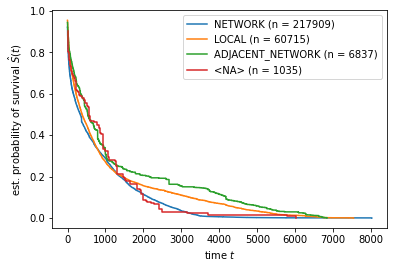

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.03,0.03,0.04


,count,median,min,max,std,mean
agg,,,,,,
NETWORK,217909,338.0,0,8019,927.010058,730.287909
LOCAL,60715,386.0,0,7538,1422.772836,977.311422
ADJACENT_NETWORK,6837,532.0,0,6839,1675.245537,1240.643118
<NA>,1035,575.0,0,6012,1009.880594,858.071498


impact.availability
{'PARTIAL': 0, 'NONE': 1, 'COMPLETE': 2, <NA>: 3}


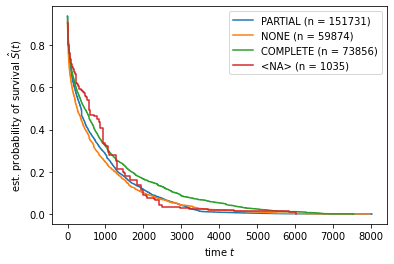

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.02,0.02,0.02


,count,median,min,max,std,mean
agg,,,,,,
PARTIAL,151731,357.0,0,8019,952.030280,741.589734
NONE,59874,256.0,0,7969,1017.838573,698.482580
COMPLETE,73856,449.0,0,7538,1329.165264,983.169275
<NA>,1035,575.0,0,6012,1009.880594,858.071498


impact.confidentiality
{'NONE': 0, 'PARTIAL': 1, 'COMPLETE': 2, <NA>: 3}


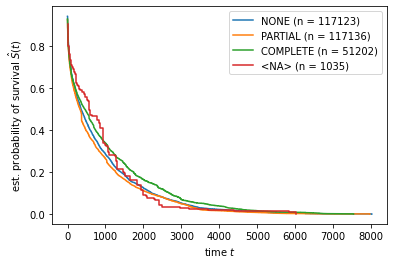

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.0,0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
NONE,117123,353.0,0,8019,1067.856430,794.261341
PARTIAL,117136,323.0,0,7969,1010.691870,729.228760
COMPLETE,51202,448.0,0,7538,1240.012232,947.440276
<NA>,1035,575.0,0,6012,1009.880594,858.071498


impact.integrity
{'NONE': 0, 'PARTIAL': 1, 'COMPLETE': 2, <NA>: 3}


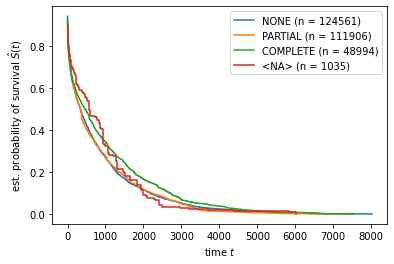

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,286496.0,1.0,354.0,0.969863,0.01,0.01,0.01


,count,median,min,max,std,mean
agg,,,,,,
NONE,124561,337.0,0,8019,1071.702347,771.511765
PARTIAL,111906,346.0,0,7458,1009.287718,751.277447
COMPLETE,48994,466.0,0,7538,1237.622493,954.878495
<NA>,1035,575.0,0,6012,1009.880594,858.071498


<Figure size 432x288 with 0 Axes>

In [82]:
for v in vnames:
    naive_compute(v)